Logistic Regression (Balanced) Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1388
           1       0.74      1.00      0.85        73

    accuracy                           0.98      1461
   macro avg       0.87      0.99      0.92      1461
weighted avg       0.99      0.98      0.98      1461



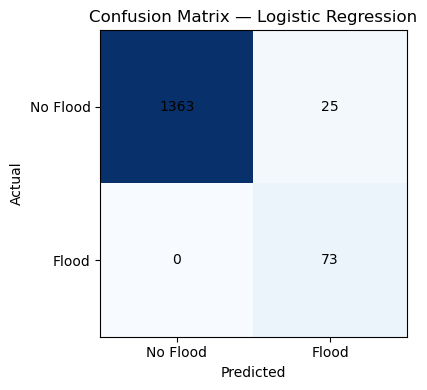

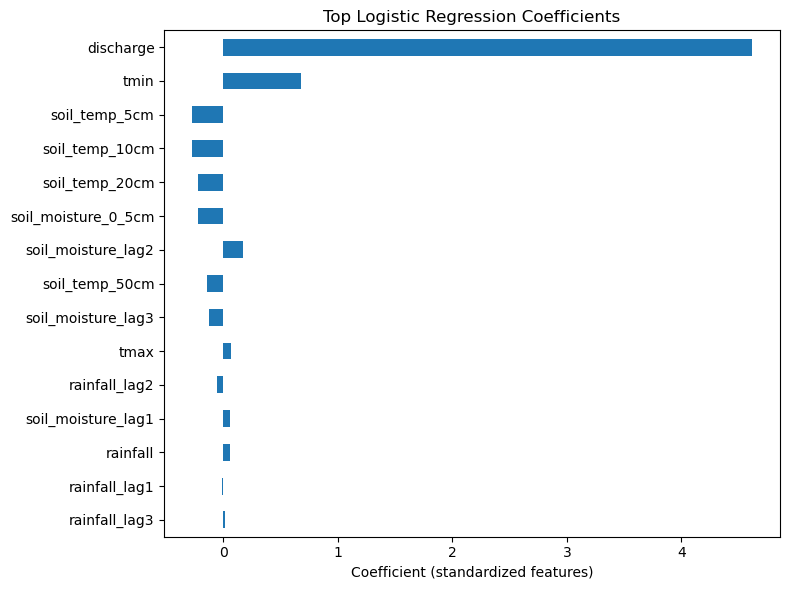

ROC-AUC (LR): 1.000


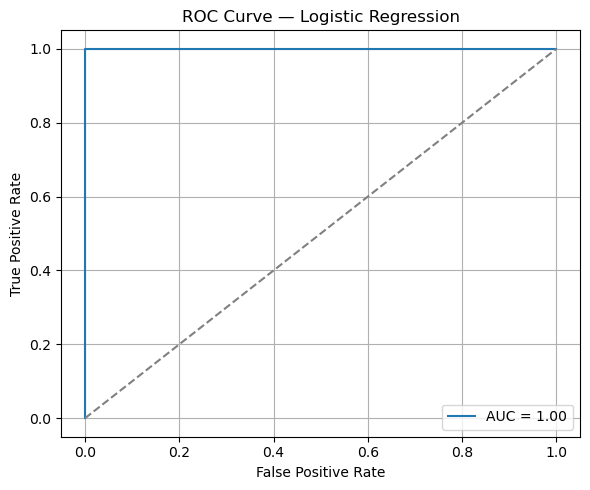

CV F1 (LR): [0.81111111 0.75789474 0.82022472 0.79558011 0.82758621] Mean: 0.8024793768896258


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# ---- Loading the data --------------------------
df = pd.read_csv("flood_model_lagged.csv", parse_dates=["date"])
X = df.drop(columns=["date", "flood"])
y = df["flood"]

## ---- Train / test split-------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# ---- Logistic Regression with scaling + class imbalance handling------- 
######### Note: scaling matters for LR; class_weight balances the rare flood class.-------------------------------
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        class_weight="balanced",
        penalty="l2",
        solver="liblinear",   
        max_iter=2000,
        random_state=42
    ))
])

pipe_lr.fit(X_train, y_train)

# ---- Predictions + probabilities section--------
y_pred = pipe_lr.predict(X_test)

#########predicting probability for ROC; section----------
y_proba = pipe_lr.predict_proba(X_test)[:, 1]

# confusion matricx and test section-----------------------------------
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
print("Logistic Regression (Balanced) Report:\n",
      classification_report(y_test, y_pred, digits=2))

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.xticks([0,1], ["No Flood","Flood"])
plt.yticks([0,1], ["No Flood","Flood"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

# the section of “Feature Importance” for LR = coefficients ----------------------
# as well the Positive coefficient => raises flood probability; negative => lowers.-------------------------
lr = pipe_lr.named_steps["lr"]
coef = pd.Series(lr.coef_.ravel(), index=X.columns)
coef_sorted = coef.reindex(coef.abs().sort_values(ascending=False).index)

plt.figure(figsize=(8,6))
coef_sorted.head(15)[::-1].plot(kind="barh")
plt.title("Top Logistic Regression Coefficients")
plt.xlabel("Coefficient (standardized features)")
plt.tight_layout(); plt.show()

# the section of ROC Curve and  AUC ------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC (LR): {roc_auc:.3f}")

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True); plt.tight_layout(); plt.show()

# the section of Cross-validation ----------------
scores = cross_val_score(pipe_lr, X, y, cv=5, scoring="f1")
print("CV F1 (LR):", scores, "Mean:", scores.mean())
